## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
len(df.query('converted == 1'))/len(df['converted'])

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
len(df.query('group == "treatment" and landing_page != "new_page" or group == "control" and landing_page != "old_page"'))

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
messy_data= df.query('group == "treatment" and landing_page != "new_page" or group == "control" and landing_page != "old_page"')
df2 = df.drop(messy_data.index)


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated('user_id', keep=False) == True]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2['user_id'].drop_duplicates(keep='first', inplace=True)

In [15]:
df2.shape

(290585, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_conv = df2.query('group == "control"')['converted'].mean()
control_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_conv = df2.query('group == "treatment"')['converted'].mean()
treatment_conv

0.11880724790277405

d. What is the probability that an individual received the new page?

In [19]:
len(df2.query('landing_page == "new_page"'))/len(df2['user_id'])

0.5000653855683727

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [20]:
diff_conv = treatment_conv - control_conv
diff_conv

-0.0015790565976871451

More rigorous methods are needed to conclude that the new treatment page leads to more conversions. However, the results show that the new page doesn't lead to more conversions so far. 

In [47]:
df['timestamp'].min(), df['timestamp'].max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.



$$H_0: P_{new} - P_{old}  ≤ 0$$


$$H_1: P_{new} - P_{old} > 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = df2.query('group == "treatment"').user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query('group == "control"').user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_mean = new_page_converted.mean()

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_mean = old_page_converted.mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_mean - old_mean


-0.00089002952204354779

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    new_mean = new_page_converted/n_new
    old_page_converted = np.random.binomial(n_old, p_old)
    old_mean = old_page_converted/n_old
    p_diffs.append(new_mean - old_mean)
    

In [29]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

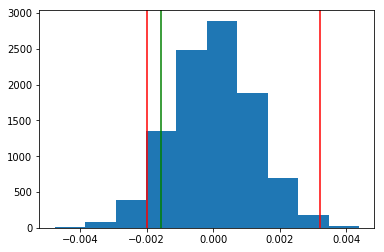

In [30]:
obs_diff = treatment_conv - control_conv
low, upper = np.percentile(p_diffs, 5), np.percentile(p_diffs, 99.5)
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='green')
plt.axvline(x=low, color='red')
plt.axvline(x=upper, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.90080000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Based on the data, it is counted with evidence to fail to reject the null hypothesis, that is to say, the new landing page does not show a significative higher probability of conversion rate in comparison with the old landing page. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = len(df2.query('group == "control" and converted == 1'))
convert_new = len(df2.query('group == "treatment" and converted == 1'))
n_old = df2.query('group == "control"').user_id.nunique()
n_new = df2.query('group == "treatment"').user_id.nunique()


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

A Z-score for a right unilateral test, the critical Z-value is 1.64 and the Z-score computed was -1.31, so it does not fall in the rejection region, that is to say, we fail to reject the null. Similarly to the previous results,  the p-value suggests that new landing page does not show a significative improve on the probability of conversion in comparison with the old page. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

It should perform a logistic regression model because the response variable is categorical (converted) with only two possible outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1

df2[['old_page', 'new_page']] = pd.get_dummies(df2['landing_page'])

df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jul 2019   Pseudo R-squ.:               8.085e-06
Time:                        04:46:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value in Part III associated with the ab_page is 0.19 and the p-value in Part II was ~ 0.9050 (Z-Test built-in) and ~ 0.9052 (walkthrough code). The difference between the p-value in part II and part III is related to the hypothesis system, that is to say,  in part II of hypothesis testing, the null hypothesis was about the higher probability of conversion in the old page in comparison with the new page (one-tailed test), on the other hand, in part III of the regression approach, the null hypothesis of the logistic regression is about the relationship between the independent variable (ab_page, in this case) and the response variable (conversion) (two-tailed test).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to consider other factors to add to the regression model because the model can be improved, fit more complex relationships in the data and show amazing insights. The disadvantage that could be shown is a more difficult interpretation or overfitting / underfitting of the model. 
 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_data = pd.read_csv('countries.csv')
countries_data.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
df2 = df2.join(countries_data.set_index('user_id'), on='user_id')
df2[['US', 'UK', 'CA']] = pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,new_page,ab_page,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1


In [44]:
logit_mod2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'UK']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Thu, 04 Jul 2019   Pseudo R-squ.:               2.324e-05
Time:                        05:17:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

In [43]:
# Calculating the exponential of ab_page, US and UK 
np.exp(-0.0150), np.exp(-0.0408), np.exp(0.0099)

(0.98511193960306265, 0.96002111497165088, 1.0099491671175422)

In [44]:
# Calculatin the reciprocal of ab_page and US
1/np.exp(-0.0150), 1/np.exp(-0.0408)

(1.0151130646157189, 1.0416437559600236)

It appears that the country had not an impact on conversion, the coefficient and respective p_vale of ab_page variable it stayed the same and the p-values of the US and UK countries does not show a significative correlation.



h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [49]:
df2['US_page'] = df2['US'] * df2['ab_page']
df2['UK_page'] = df2['UK'] * df2['ab_page']

In [50]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,new_page,ab_page,country,US,UK,CA,US_page,UK_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1,0,0


In [52]:
logit_mod3 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'US_page', 'UK', 'UK_page']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Thu, 04 Jul 2019   Pseudo R-squ.:               3.483e-05
Time:                        05:19:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.506      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Conclusion**



**-** On Part I, the data shows 294478 records of 5 variables as a result of A/B testing, its duration is less than one month. 

**-** The messy data was handled with removing the rows that did not match with the correct classification of group and landing page. 

**-** In the probability and hypothesis testing (Part II), the new page does not show any improvement in conversion in comparison with the old page.

**-** Similarly, in the regression approach (Part III), the conversion does not appear to be correlated with the type of landing page (old/new) or the user's country.

**-** The new landing page does not show any statistically significant difference regarding the conversion in none of the approaches used. 

**-** In practice, it does not seem any reason to change the old landing page with the new one. It's not clear (at least to me) if the duration of the A/B testing has to be larger in this situation, I think it's not worth it.



<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0